In [9]:
import logging
import pandas as pd
import itertools
import optuna
import numpy as np
import matplotlib.pyplot as plt

from concurrent.futures import ProcessPoolExecutor
from scipy.stats import zscore
from datetime import datetime, timedelta
from data_loading_finance.loading_data import LoadingData
from ts_tools.tools import tools
from prophet import Prophet
from prophet.diagnostics import cross_validation, performance_metrics

[*********************100%%**********************]  1 of 1 completed

Getting info for ticker AAPL...


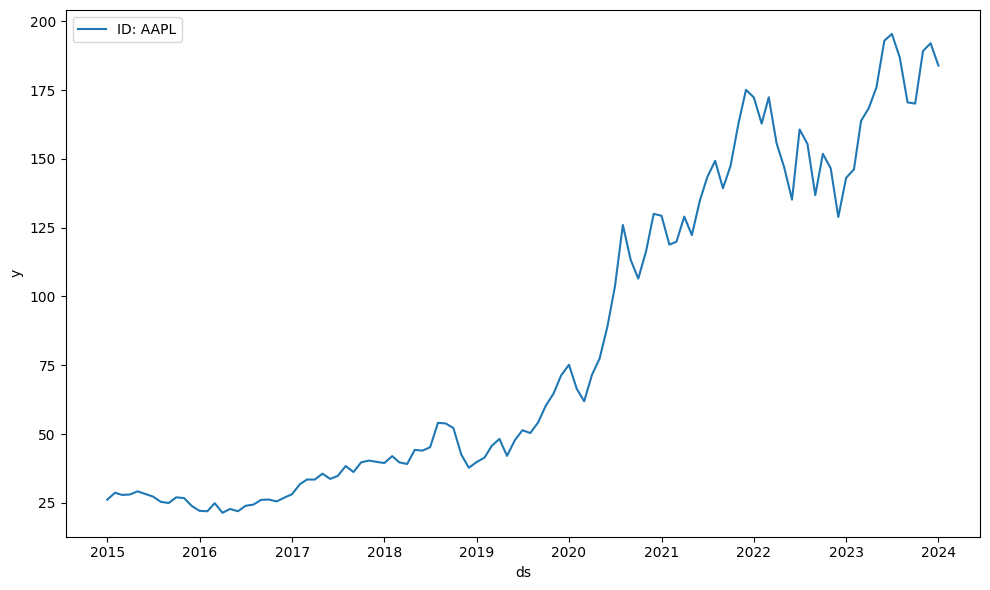

In [10]:
# Cargar datos y preprocesarlos
tickers = ['AAPL']
loader = LoadingData(tickers=tickers)
ts = loader.get_data(start_date='2015-01-01', end_date='2024-01-31', interval='1mo')
info = loader.get_info_ticker()

ts_tools = tools()
ts = ts_tools.ts_prepartion(ts, 'Date', 'Adj Close')

# Graficar los datos
ts_tools.plot_ts(ts)

In [11]:
# Configuración de logging
logging.getLogger("prophet").setLevel(logging.ERROR)
logging.getLogger("cmdstanpy").disabled = True
optuna.logging.set_verbosity(optuna.logging.ERROR)

proporcion_entrenamiento = 0.80
horizon_months = 3
fourier_order = 4

def detect_and_correct_anomalies(group):
    group = group.sort_values(by='ds', ascending=True).reset_index(drop=True)
    group['Z-Score'] = abs(zscore(group['y']))

    # Detectar y corregir anomalías
    group.loc[group['Z-Score'] > 2, 'y'] = np.nan
    group['y'] = group['y'].interpolate(method='linear')

    # Eliminar la columna Z-Score
    group = group.drop(columns=['Z-Score'])

    return group

ts_not_anom= ts.groupby('unique_id').apply(detect_and_correct_anomalies).reset_index(drop=True)
ts_not_anom_by_client = ts_not_anom.groupby('unique_id')

/var/folders/dt/cxyz36h16ydfv1yg6n6v5fqm0000gn/T/ipykernel_6277/139569358.py:23: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  ts_not_anom= ts.groupby('unique_id').apply(detect_and_correct_anomalies).reset_index(drop=True)


<function matplotlib.pyplot.show(close=None, block=None)>

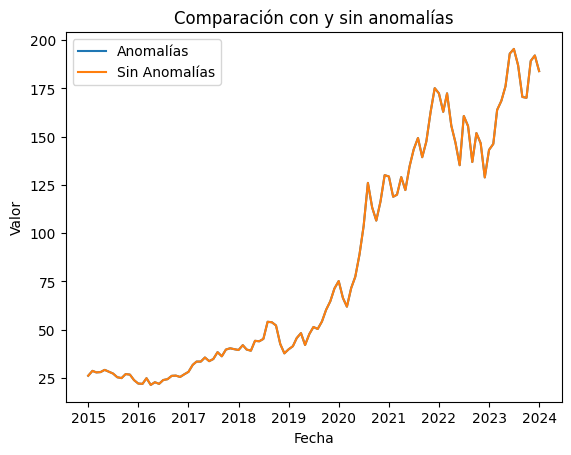

In [12]:
## Comparación con y sin anomalías
plt.plot(ts_not_anom['ds'], ts_not_anom['y'])
plt.plot(ts['ds'], ts['y'])
plt.legend(['Anomalías', 'Sin Anomalías'])
plt.title('Comparación con y sin anomalías')
plt.xlabel('Fecha')
plt.ylabel('Valor')
plt.show

In [13]:
# Inicialización de DataFrames para resultados
forecast_result_list = []
modelo_precision_forecast_list = []
timestamp = datetime.now().strftime('%Y-%m-%d')

# Función para realizar la optimización con Optuna
def optimize_prophet(trial, ts_prophet, training_duration, horizon, cutoffs):
    param_grid = {
        'changepoint_prior_scale': trial.suggest_float('changepoint_prior_scale', 0.01, 50.0, log=True),
        'seasonality_prior_scale': trial.suggest_float('seasonality_prior_scale', 0.01, 50.0, log=True),
        'holidays_prior_scale': trial.suggest_float('holidays_prior_scale', 0.01, 50.0, log=True),
        'n_changepoints': trial.suggest_int('n_changepoints', 10, 50),
        'seasonality_mode': trial.suggest_categorical('seasonality_mode', ['additive', 'multiplicative']),
        'growth': trial.suggest_categorical('growth', ['linear', 'flat']),
        'changepoint_range': trial.suggest_float('changepoint_range', 0.5, 0.9)
    }

    model = Prophet(**param_grid, yearly_seasonality=True, weekly_seasonality=False, daily_seasonality=False, interval_width=0.9)
    model.add_country_holidays(country_name='ES')

    model.fit(ts_prophet)
    df_cv_model = cross_validation(model, initial=timedelta(days=training_duration), horizon=timedelta(days=horizon), disable_tqdm=True, parallel='threads', cutoffs=cutoffs)
    df_metrics = performance_metrics(df_cv_model, monthly=True)

    smape_score = df_metrics['smape'].values[0]
    return smape_score

In [14]:
# Función para realizar el forecasting para cada cliente
def forecast_for_client(id, ts, horizon_months, proporcion_entrenamiento):
    try:
        #Ajuste de la serie temporal
        ts = ts.drop('unique_id', axis=1).sort_values(by='ds').reset_index(drop=True)
        ts['ds'] = pd.to_datetime(ts['ds'])

        # Horizon para el forecast
        horizon_months = horizon_months
        horizon = horizon_months * 30.5

        # Splitting Training y Validación
        indice_entrenamiento = int(len(ts) * proporcion_entrenamiento)
        ts_entrenamiento = ts[:indice_entrenamiento]
        ts_validacion = ts[indice_entrenamiento:]
        ts_prophet = pd.concat([ts_entrenamiento, ts_validacion]).reset_index(drop=True)

        # Implementación del modelo Prophet
        training_duration = len(ts_entrenamiento) * 30.5
        cutoffs = pd.date_range(start=ts_validacion['ds'].min(), end=ts_validacion['ds'].max() - timedelta(days=horizon), freq='MS')

        study = optuna.create_study(direction='minimize')
        study.optimize(lambda trial: optimize_prophet(trial, ts_prophet, training_duration, horizon, cutoffs), n_trials=50)

        best_params = study.best_trial.params
        model = Prophet(**best_params, yearly_seasonality=True, weekly_seasonality=False, daily_seasonality=False, interval_width=0.9)
        model.add_country_holidays(country_name='ES')

        model.fit(ts_prophet)
        df_cv_model = cross_validation(model, initial=timedelta(days=training_duration), horizon=timedelta(days=horizon), disable_tqdm=True,  parallel='threads', cutoffs=cutoffs)
        df_metrics = performance_metrics(df_cv_model, rolling_window=-1, monthly=True)
        smape_score = df_metrics['smape'].values[0]
        mape_score = df_metrics['mape'].values[0] if 'mape' in df_metrics.columns else None

        accuracy = round((1 - smape_score) * 100, 2) if smape_score < 1 else 0.00

        #### Global Accuracy ###
        last_cutoff = df_cv_model['cutoff'].max()
        df_cv_model_accuracy = df_cv_model[df_cv_model['cutoff'] == last_cutoff]
        total_real = df_cv_model_accuracy['y'].sum()
        total_forecast = df_cv_model_accuracy['yhat'].sum()

        if total_real == 0 and total_forecast == 0:
            smape_global = 0.0
        else:
            smape_global = 2 * np.mean(np.abs(total_real - total_forecast)) / (np.abs(total_real) + np.abs(total_forecast))

        min_smape = min(smape_score, smape_global)
        accuracy_general = round((1 - min_smape) * 100, 2) if min_smape <=1 else 0.00
        #####

        future = model.make_future_dataframe(periods=horizon_months, freq='MS', include_history=False)
        forecast = model.predict(future)

        resultado_accuracy = {
            'ticker': id,
            'accuracy': accuracy_general,
            'timestamp': timestamp
        }

        forecast['ticker'] = id
        forecast['yhat'] = forecast['yhat'].round(2)
        forecast['ds'] = forecast['ds'].dt.strftime('%d-%m-%Y')

        return resultado_accuracy, forecast[['ticker', 'ds', 'yhat']].to_dict('records')
    except Exception as e:
        logging.error(f'Error procesando {id}. No existe suficiente información para realizar el forecasting: {e}')
        return None, None

# Ejecución en paralelo
with ProcessPoolExecutor() as executor:
    futures = [executor.submit(forecast_for_client, id, ts, horizon_months, proporcion_entrenamiento) for id, ts in ts_not_anom_by_client]
    for future in futures:
        try:
            result = future.result()
            if result is not None:
                resultado_accuracy, forecast_records = result
                modelo_precision_forecast_list.append(resultado_accuracy)
                if forecast_records is not None:
                    forecast_result_list.extend(forecast_records)
        except Exception as e:
            print(f'Error processing future: {e}')

Error processing future: A process in the process pool was terminated abruptly while the future was running or pending.


Process SpawnProcess-2:
Traceback (most recent call last):
  File "/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/multiprocessing/process.py", line 314, in _bootstrap
    self.run()
  File "/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/multiprocessing/process.py", line 108, in run
    self._target(*self._args, **self._kwargs)
  File "/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/concurrent/futures/process.py", line 249, in _process_worker
    call_item = call_queue.get(block=True)
                ^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/multiprocessing/queues.py", line 122, in get
    return _ForkingPickler.loads(res)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^
AttributeError: Can't get attribute 'forecast_for_client' on <module '__main__' (built-in)>


In [15]:
# Filtrar elementos None de las listas
modelo_precision_forecast_list = [item for item in modelo_precision_forecast_list if item is not None]
forecast_result_list = [item for item in forecast_result_list if item is not None]

# Crear los dataframes pandas de los resultados
modelo_precision_forecast = pd.DataFrame(modelo_precision_forecast_list)
forecast_result = pd.DataFrame(forecast_result_list)